# TP 6 - Procesamiento de Imagenes
Grupo 4 <br>
Integrantes:
- Pablo Smolkin
- Pedro Carranza Vélez
- Philippe Dutriez Diaz
- Francisco Daniel Ledesma

Nota: Las funciones utilizadas se encuentran en el archivo functions.py

In [2]:
from sys import path
from os.path import realpath
path.append(realpath("../")) # Makes it works everywhere
from common.functions import *
import cv2

In [3]:
from functions import *

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
flags = [i for i in dir(cv2) if i.startswith("COLOR_")]

In [6]:
len(flags)

346

In [7]:
flags[40]

'COLOR_BAYER_GR2GRAY'

***
## 1.a - Nemo Segmentation

In [8]:
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import cm
from matplotlib.colors import hsv_to_rgb

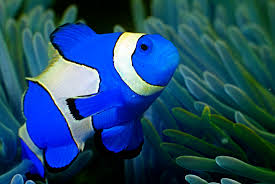

In [9]:
nemo = cv2.imread("img/nemo0.jpg")
h, w = nemo.shape[:2]
displayImage_fromcv2(nemo, w, h)

OpenCV lee por defecto las imagenes en BGR, por lo cual es necesario una conversión a RGB para poder visualizarla correctamente.

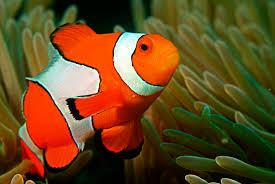

In [10]:
nemo = cv2.cvtColor(nemo, cv2.COLOR_BGR2RGB)
h, w = nemo.shape[:2]
displayImage_fromcv2(nemo, w, h)

Si proyectamos los valores de color RGB como coordenadas en el espacio, donde por ejemplo, un pixel rojo tendrá coordenadas (255, 0, 0), y uno negro tendrá (0, 0, 0). Obtendremos una distribución de pixeles en el espacio.

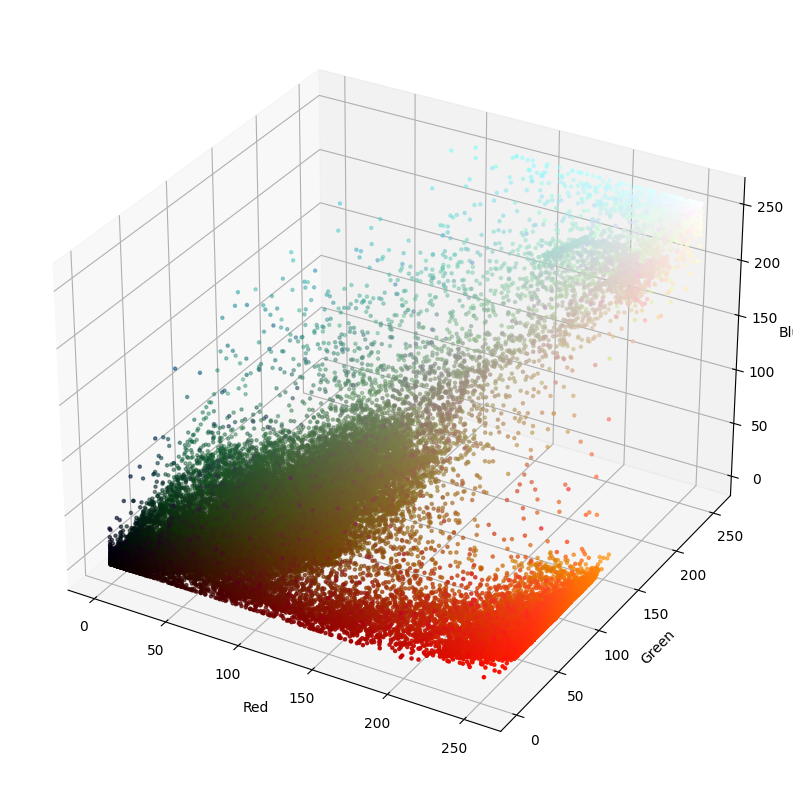

In [11]:
# Splitting components of image
r, g, b = cv2.split(nemo)

# Creating Figure for 3D plot
fig = plt.figure(figsize=(10,10))
axis = fig.add_subplot(1, 1, 1, projection='3d')

# Normalising list of pixels
pixel_colors = nemo.reshape((np.shape(nemo)[0] * np.shape(nemo)[1], 3))
norm = colors.Normalize(vmin=-1., vmax=1.)
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()

# Plotting
axis.scatter(r.flatten(), g.flatten(), b.flatten(), facecolors=pixel_colors, marker='.')
axis.set_xlabel("Red")
axis.set_ylabel("Green")
axis.set_zlabel("Blue")
plt.show()

Si bien, el sistema RGB es más facil de entender por nosotros y es ampliamente usado para la representación de colores, no es tan util para segmentar un color en particular. Esta tarea es más sencilla si convertimos la imágen al sistema HSV, para poder segmentar un color.

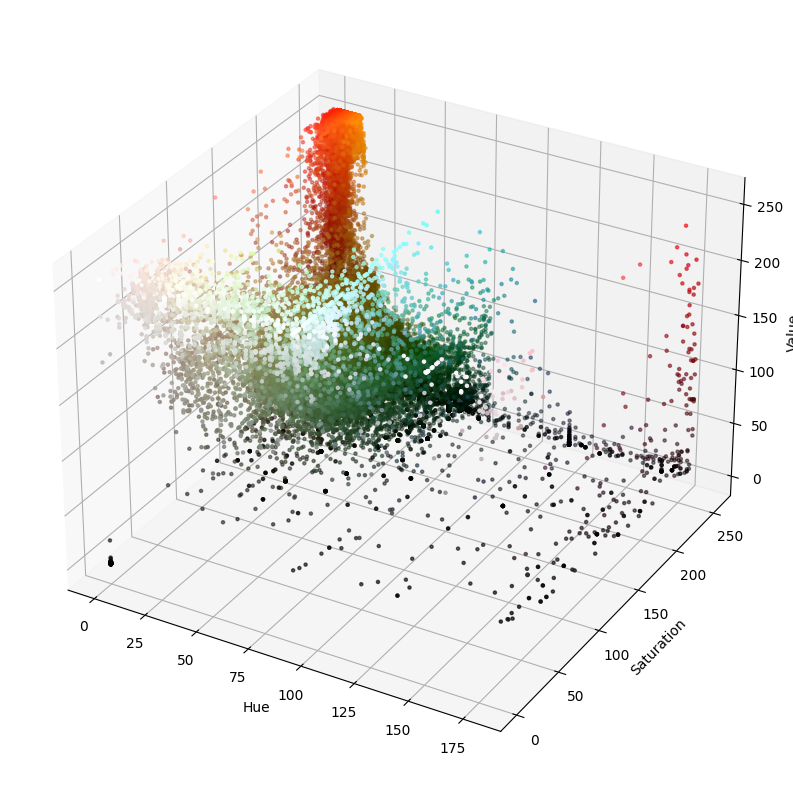

In [12]:
hsv_nemo = cv2.cvtColor(nemo, cv2.COLOR_RGB2HSV) # Convert the image from RGB to HSV

# Plotting distribution of pixels in 3D HSV colour space
h, s, v = cv2.split(hsv_nemo)
fig = plt.figure(figsize=(10,10))
axis = fig.add_subplot(1, 1, 1, projection="3d")

axis.scatter(h.flatten(), s.flatten(), v.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Hue")
axis.set_ylabel("Saturation")
axis.set_zlabel("Value")
plt.show()

Para el segundo gráfico se mantuvo la misma paleta de colores de los puntos, para poder ver que la separación del naranja en HSV es más apreciable.
A continuación se aplica una máscara para poder segmentar el color naranja de la imágen.

In [13]:
# Thresholds for segmenting Nemo
light_orange = (1, 190, 200)
dark_orange = (18, 255, 255)

In [14]:
# Segmenting Nemo according to thresholds, using a mask
mask = cv2.inRange(hsv_nemo, light_orange, dark_orange)
segmented_nemo = cv2.bitwise_and(nemo, nemo, mask=mask)

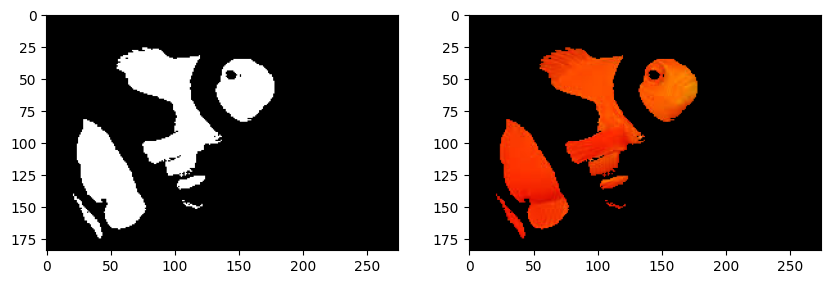

In [15]:
fig = plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.imshow(mask, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(segmented_nemo)
plt.show()

Ahora se aplica una máscara para poder segmentar el color blanco de la imágen.

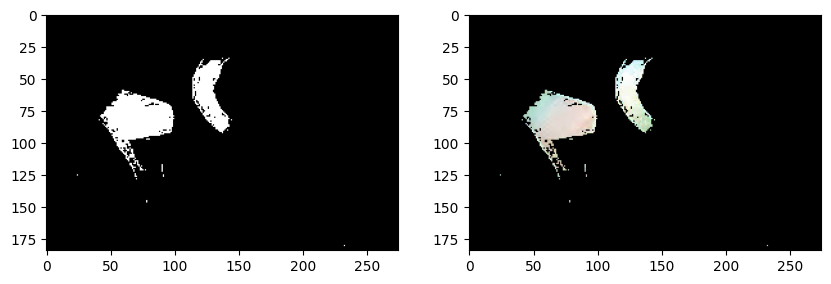

In [16]:
# Segmenting white stripes of Nemo
light_white = (0, 0, 200)
dark_white = (145, 60, 255)

mask_white = cv2.inRange(hsv_nemo, light_white, dark_white)
result_white = cv2.bitwise_and(nemo, nemo, mask=mask_white)

fig = plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.imshow(mask_white, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(result_white)
plt.show()

Ahora utilizando ambas máscaras, se obtiene la segmentación completa de Nemo.

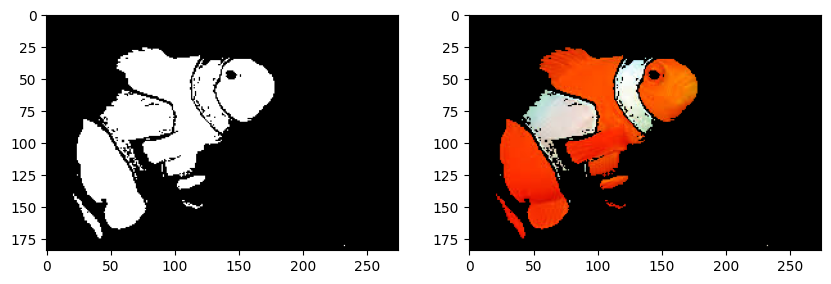

In [17]:
# Segmenting both white and orange parts of Nemo
final_mask = mask + mask_white
final_result = cv2.bitwise_and(nemo, nemo, mask=final_mask)

fig = plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.imshow(final_mask, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(final_result)
plt.show()

Aparecen unos puntos negros no deseados en la segmentación, para reducirlos se aplica un pasabajos gausseano que nos da una imágen más continua, sacando esas falsas detecciones.

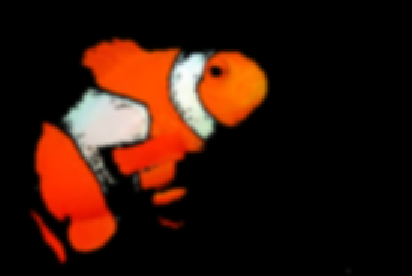

In [18]:
# Blurring to smoothen dark dots in the middle of Nemo
blur = cv2.GaussianBlur(final_result, (7, 7), 0)

h, w = blur.shape[:2]
displayImage_fromcv2(blur, int(w*1.5), int(h*1.5))

Ahora probamos todo este mismo procedimiento pero con otra imágen.

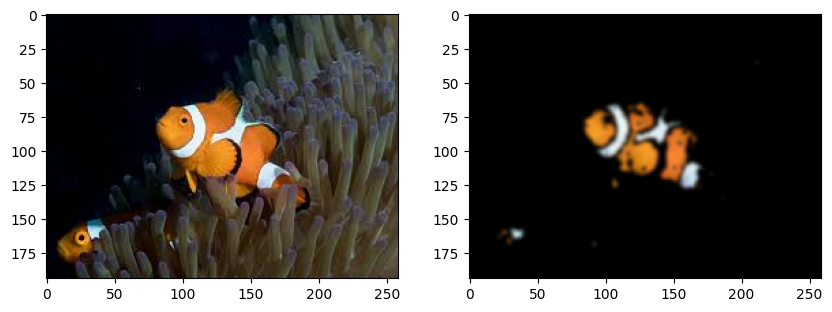

In [19]:
nemos_friend = cv2.imread("img/nemo5.jpg")
nemos_friend = cv2.cvtColor(nemos_friend, cv2.COLOR_BGR2RGB)
result = segment_fish(nemos_friend)
fig = plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.imshow(nemos_friend)
plt.subplot(1, 2, 2)
plt.imshow(result)
plt.show()

Se puede ver como la segmentación para una imágen de un pez con cierta luz, tono y fondo no puede ser generalizado para cualquier imágen, pero si una aproximación aceptable. 

***
## 1.b - Aplicar los conceptos a la imagen bird.jpg

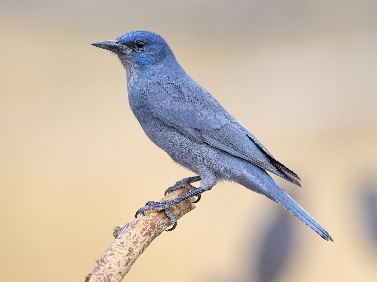

In [20]:
bird = cv2.imread("img/bird.jpg")
bird = cv2.cvtColor(bird, cv2.COLOR_BGR2RGB)
h, w = bird.shape[:2]
displayImage_fromcv2(bird, w//5, h//5)

Convertimos a HSV para poder segmentar el color

In [21]:
hsv_bird = cv2.cvtColor(bird, cv2.COLOR_RGB2HSV) # Convert the image from RGB to HSV

In [22]:
# Normalising list of pixels
pixel_colors_bird = bird.reshape((np.shape(bird)[0] * np.shape(bird)[1], 3))
norm = colors.Normalize(vmin=-1., vmax=1.)
norm.autoscale(pixel_colors_bird)
pixel_colors = norm(pixel_colors_bird).tolist()

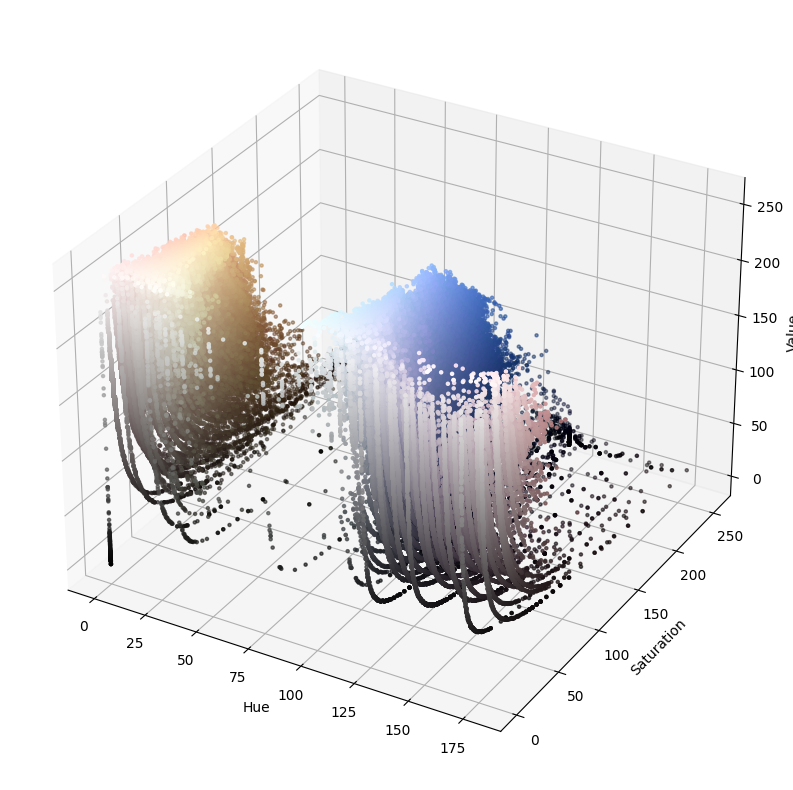

In [23]:
# Plotting distribution of pixels in 3D HSV colour space
h, s, v = cv2.split(hsv_bird)
fig = plt.figure(figsize=(10,10))
axis = fig.add_subplot(1, 1, 1, projection="3d")

axis.scatter(h.flatten(), s.flatten(), v.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Hue")
axis.set_ylabel("Saturation")
axis.set_zlabel("Value")
plt.show()

In [24]:
# Thresholds for segmenting Bird
light_blue = (100,0,0) 
dark_blue = (142, 255, 255)

In [25]:
# Segmenting bird according to thresholds, using a mask
mask = cv2.inRange(hsv_bird, light_blue, dark_blue)
segmented_bird = cv2.bitwise_and(bird, bird, mask=mask)

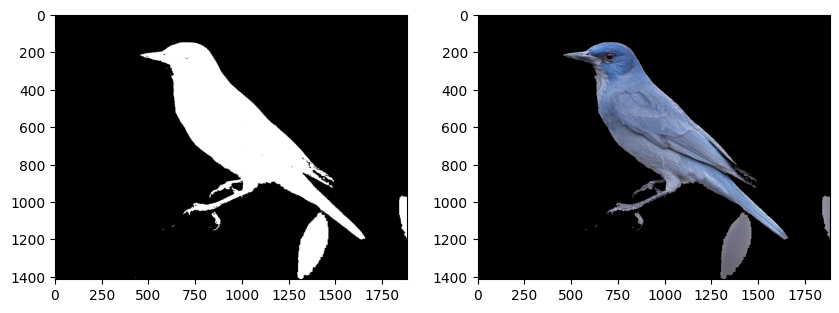

In [26]:
fig = plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.imshow(mask, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(segmented_bird)
plt.show()

Observamos que si bien se elimino gran parte del contenido quedo un manchon en gris con tonalidades de azul, para esto se busca primero remover esa parte.

In [27]:
light_blue = (75, 0, 110)
dark_blue = (175, 50, 165)

In [28]:
# Segmenting bird according to thresholds, using a mask
mask_blue = 255 - cv2.inRange(hsv_bird, light_blue, dark_blue)
segmented_bird = cv2.bitwise_and(bird, bird, mask=mask_blue)

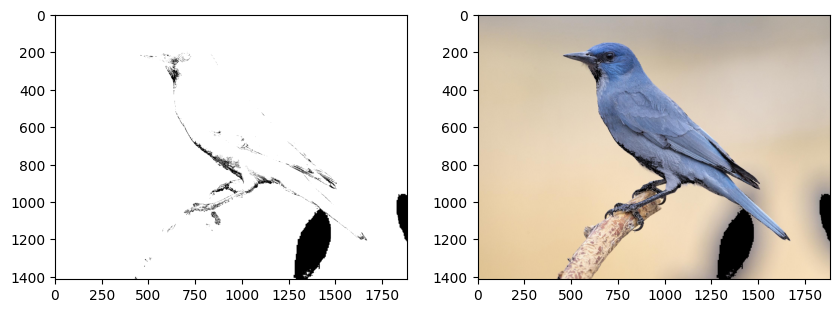

In [29]:
result_blue = cv2.bitwise_and(segmented_bird, segmented_bird, mask=mask_blue)
fig = plt.figure()
fig.set_size_inches(10, 10)
plt.subplot(1, 2, 1)
plt.imshow(mask_blue, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(result_blue)
plt.show()

Una vez eliminada se vuelve a aplicar el filtro y se obtiene la imagen del ave aislada.

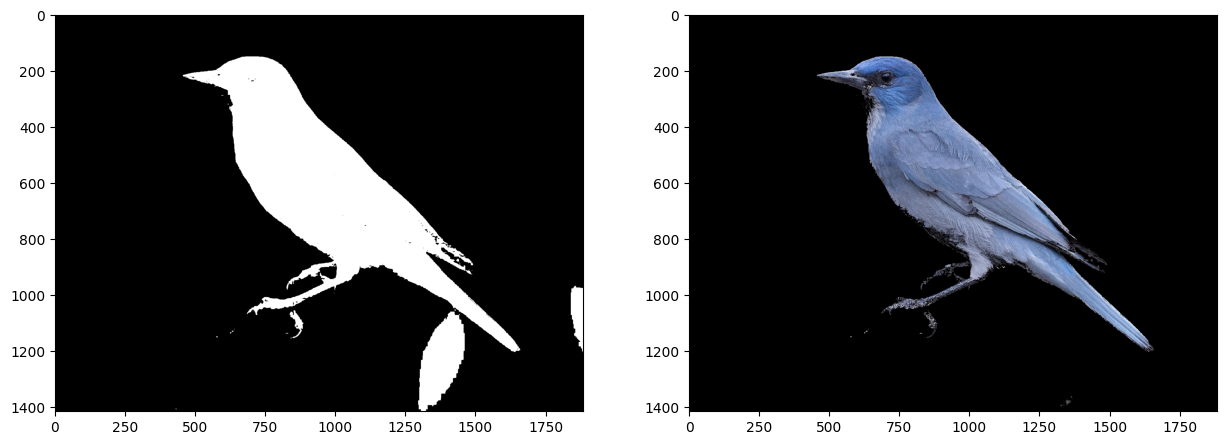

In [30]:
# Thresholds for segmenting Bird
light_blue = (100,0,0) 
dark_blue = (142, 255, 255)
# Segmenting bird according to thresholds, using a mask
mask = cv2.inRange(hsv_bird, light_blue, dark_blue)
segmented_bird = cv2.bitwise_and(result_blue, result_blue, mask=mask)
fig = plt.figure(figsize=(15,15))
plt.subplot(1, 2, 1)
plt.imshow(mask, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(segmented_bird)
plt.show()

***
## 1.c - Dada la siguiente imagen se pide aislar la rosa dejando el resto en niveles de gris.

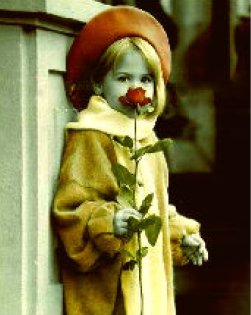

In [31]:
girl = cv2.imread("img/Girl_and_rose.jpg")
girl = cv2.cvtColor(girl, cv2.COLOR_BGR2RGB)
h, w = girl.shape[:2]
displayImage_fromcv2(girl, w, h)

In [32]:
hsv_girl = cv2.cvtColor(girl, cv2.COLOR_RGB2HSV) # Convert the image from RGB to HSV

In [33]:
# Normalising list of pixels
pixel_colors_girl = girl.reshape((np.shape(girl)[0] * np.shape(girl)[1], 3))
norm = colors.Normalize(vmin=-1., vmax=1.)
norm.autoscale(pixel_colors_girl)
pixel_colors = norm(pixel_colors_girl).tolist()

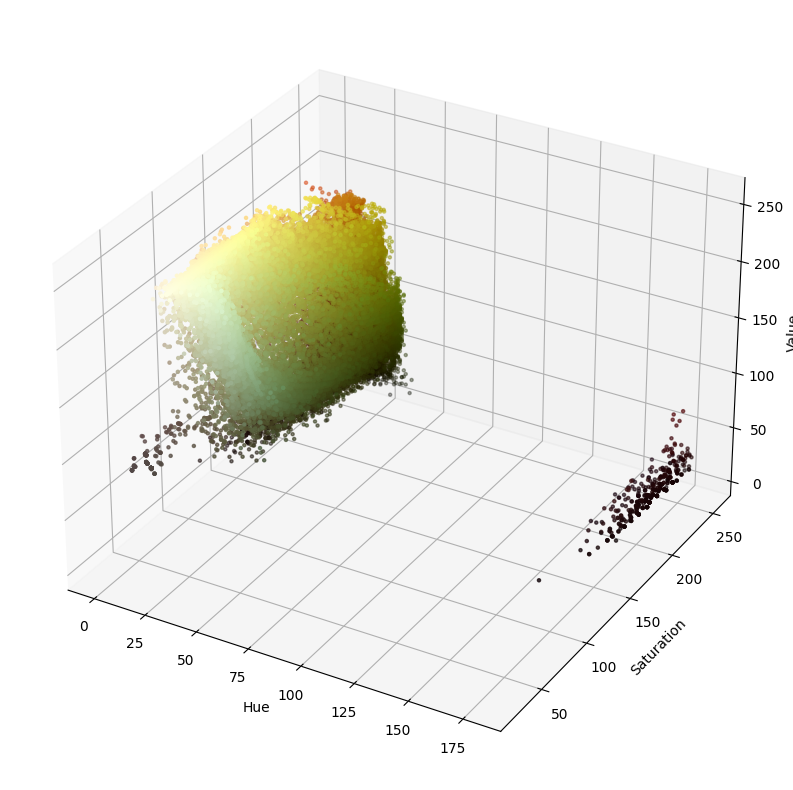

In [34]:
# Plotting distribution of pixels in 3D HSV colour space
h, s, v = cv2.split(hsv_girl)
fig = plt.figure(figsize=(10,10))
axis = fig.add_subplot(1, 1, 1, projection="3d")

axis.scatter(h.flatten(), s.flatten(), v.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Hue")
axis.set_ylabel("Saturation")
axis.set_zlabel("Value")
plt.show()

En primera instancia observamos que la imagen tiene una gran distribucion de color rojo. Aplicamos filtro correspondiente y aislamos las zonas en rojo.

In [35]:
light_red = (0, 210,70)
dark_red = (15, 255, 215)

In [36]:
# Segmenting bird according to thresholds, using a mask
mask = cv2.inRange(hsv_girl, light_red, dark_red)
segmented_girl = cv2.bitwise_and(girl, girl, mask=mask)

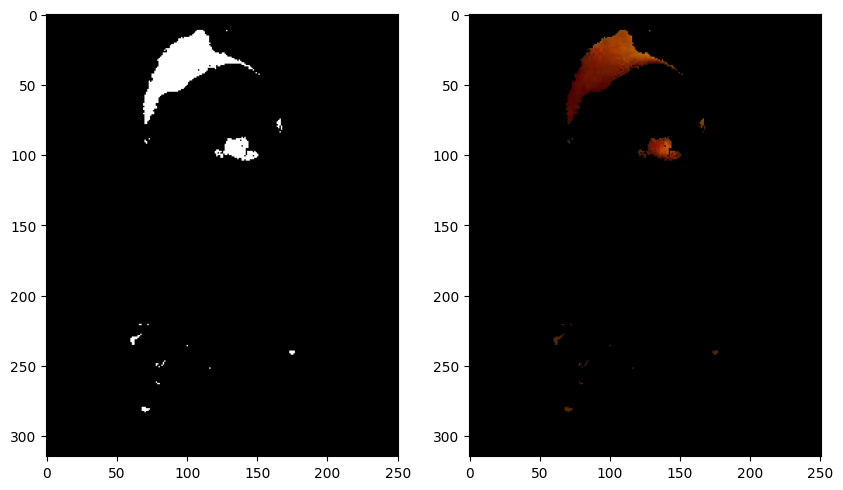

In [37]:
fig = plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.imshow(mask, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(segmented_girl)
plt.show()

Como necesito solo la parte roja de la rosa mando a 0 todo el resto de la mascara.

In [38]:
rows,cols,_ = girl.shape
for i in range(rows):
    for j in range(cols):
        if i < 80 or i > 110 or j < 100 or j>160:
            mask[i,j]=0

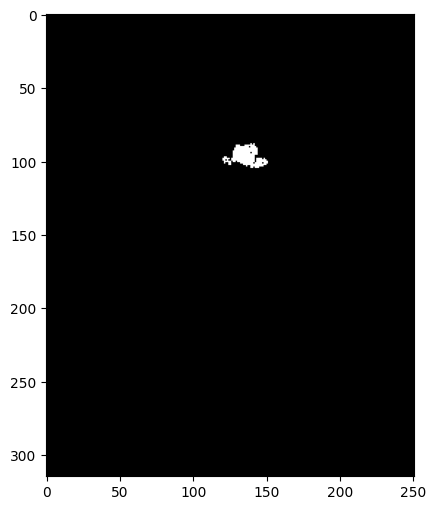

In [39]:
fig = plt.figure(figsize=(6,6))
plt.imshow(mask, cmap='gray')

A continuacion removemos la rosa de la imagen original

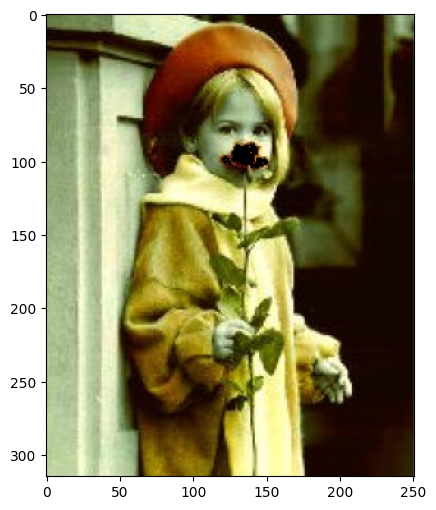

In [40]:
invMask = cv2.bitwise_not(mask)
girl_without_rose = cv2.bitwise_and(girl, girl, mask=invMask)
fig = plt.figure(figsize=(6,6))
plt.imshow(girl_without_rose, cmap='gray')

La convertimos en gris

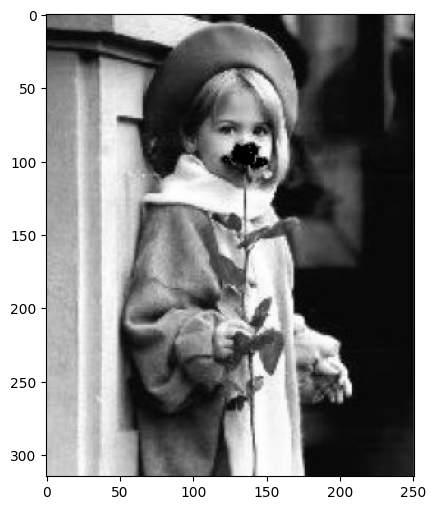

In [41]:
girl_without_rose_gray = cv2.cvtColor(girl_without_rose, cv2.COLOR_RGB2GRAY)
fig = plt.figure(figsize=(6,6))
plt.imshow(girl_without_rose_gray, cmap='gray')

Finalmente le agregamos la rosa en color y se obtiene el resultado final

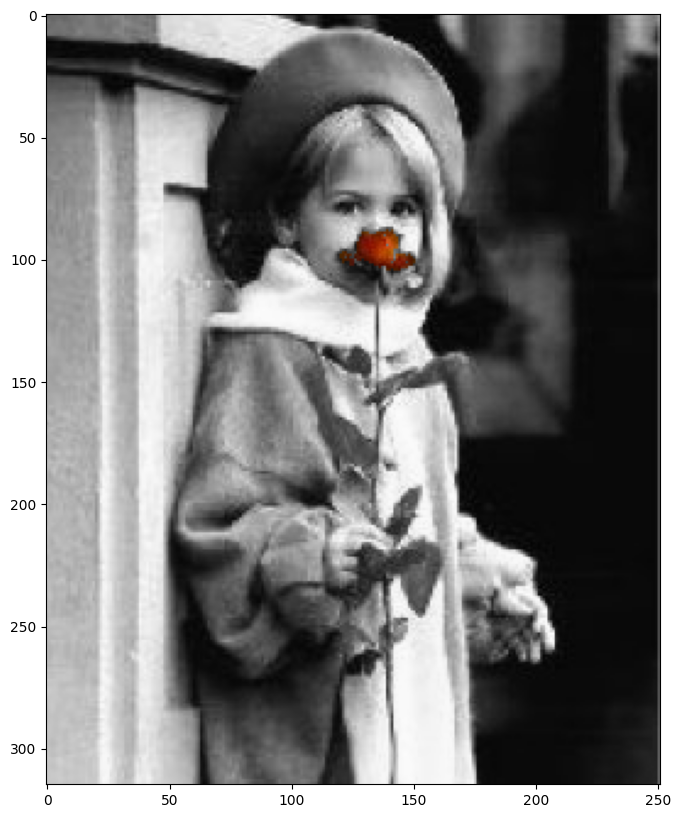

In [42]:
red_rose = cv2.bitwise_and(girl, girl, mask=mask)
girl_with_red_rose = cv2.cvtColor(girl_without_rose_gray, cv2.COLOR_GRAY2RGB) + red_rose
fig = plt.figure()
fig.set_size_inches(10, 10)
plt.imshow(girl_with_red_rose)
plt.show()

***
# 1.d K-means clustering
Investigar como se usa el algoritmo k-means clustering para segmentar el color en una imagen. Implementar un ejemplo.

#### K-means clustering

Es un algoritmo dedicado a particionar $n$ elementos en $k$ segmentos o clusters. Cada í-esimo cluster está representado por un centroide $c_i$, cuya pocisión es la media de los datos que pertenecen a ese cluster, y los elementos del í-esimo cluster se definen como aquellos que se encuentran a menor distancia de $c_i$ que de cualquier otro $c_j$ ($j = 0...k-1, j\neq i$). Lo que se obtiene finalmente es que los clusters estan formados por elementos que comparten cierta similaridad.

El proceso del algoritmo es iterativo, y funciona de la siguiente manera:

1. Se tienen dos entradas, k y los $x_0...x_{n-1}$ datos a segmentar
2. Se poscicionan los centroides $c_0...c_{k-1}$ aleatoriamente
3. Se itera:
    
    1. se obtiene el centroide más cercano para cada dato, y se lo asigna al cluster asociado
    2. se repocisiona el centroide en la media de los datos pertenecientes a su cluster

Una vez que no se modifica el centroide entre una iteración y la siguiente, se finaliza el algoritmo. En comparación a otros algoritmos de segmentción, k-means clustering es el que requiere menor computación. Si se tiene una dimensión $d$ y requieren $i$ iteraciones para su convergencia, la complejidad del algoritmo es de $O(n\cdot k\cdot d\cdot i)$. Usualmente, suele suceder que el calculo de la media puede tener cierta variación o _jitter_ o que la convergencia de la media tome mucho tiempo, por lo que se suele definir también una condición a partir de la cual finalizar el algoritmo. 

El algoritmo permite un alto nivel de abstracción, siempre y cuando los datos sean numericos. Esto significa que los datos pueden ser posciciones en el espacio o color. Esto significa que el algoritmo puede utilizarse para segmentar imagenes en base a los colores que componen. De esta manera, el algoritmo puede utilizarse como una forma de _computer vision_, donde se define cada objeto por su color.

A continuación se realiza un ejemplo utilizando la libreria OpenCV.

Se abre la imagen y se configura su formato a RGB.

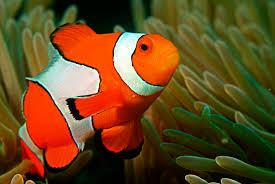

In [43]:
# abrir la imagen
image = cv2.imread("img/nemo0.jpg")
# convertir a RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# mostrar la imagen
h, w = image.shape[:2]
displayImage_fromcv2(image, w, h)

La imagen actualmente es de tres dimensiones, ancho, alto y color (los tres valores RGB). Para poder utilizar la función de OpenCV, la cual toma a los datos como arreglos de 2D, se aplana el ancho y alto en un solo vector y se mantiene el valor RGB. A su vez, la función de OpenCV toma valores de float32 para los colores. 

In [44]:
# convertir la imagen en un arreglo de pixeles
pixel_values = image.reshape((-1, 3))
# convert a float32
pixel_values = np.float32(pixel_values)

Se define el criterio de finalización para el algoritmo.

In [45]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)

Se define la cantidad de clusters y se realiza el algoritmo.

La imagen del pez se identifican cuatro colores principales, naranja, blanco, negro, y el marrón claro de la anémona, por lo que se elige k=4.

In [46]:
k = 4
_, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

_labels_ indica el label del cluster indicado, mientras que _centers_ nos indica el valor de cada centroide.

Se convierten los valores de vualta de float32 a uint8.

In [47]:
centers = np.uint8(centers)

Se crea la imagen segmentada.

In [48]:
# convertir los pixeles a los colores de los centroides
segmented_image = centers[labels.flatten()]

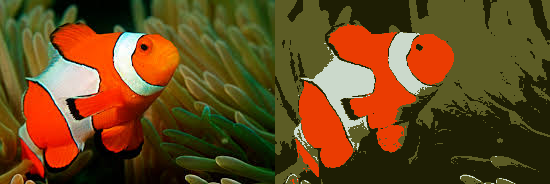

In [49]:
# volver a la forma original de la imagen
segmented_image = segmented_image.reshape(image.shape)
comparison = np.concatenate([image, segmented_image], axis=1)

# mostrar la imagen
h, w = image.shape[:2]
displayImage_fromcv2(comparison, 2*w, h)

***
# 2 - Procesamiento del Color
## a - Investigar que es el filtro de bayer y donde se usa